# Performing a general POVM on a quantum computer


### Contributors
Yordan S. Yordanov, Crispin H. W. Barnes

### Introduction

#### What is a POVM 

In quantum mechanics positive operator-valued measures (POVMs) describe the most general form of a quantum measurement. They can be used to distinguish probabilistically between non-orthogonal quantum states and are used in applications like state discrimination, quantum tomography, and qunatum encryption. 
A POVM is defined as a set of $n$ positive operators $\{\hat{E}_i\}$ that satisfy the completeness relation $ \sum_{i=1}^{n} \hat{E}_i = \hat{I}$, where $\hat{E}_i = \hat{M}_i^\dagger \hat{M}_i$ and the $\{\hat{M}_i\}$ are measurement operators. Performing a POVM on a system in initial state $|\psi_0\rangle$ results in wave function reduction to one of $n$ possible measurement outcomes $|\psi_0\rangle \rightarrow |\psi_i\rangle =\frac{\hat{M}_i|\psi_0\rangle}{\sqrt{\langle\psi_0|\hat{M}_i^{\dagger}  \hat{M}_i|\psi_0\rangle}}$, with probability $p_i = \langle\psi_0|\hat{M}_i^{\dagger}  \hat{M}_i|\psi_0\rangle$. 

#### How can POVMs be implemented

In practice POVMs are either implemented by a physical hardware, specifically tailored for the task, or simulated by quantum gate operations, in some cases involving classical post-processing. 
A well known way to perform a POVM in a deterministic way, without classical post-processing is using Neumark's theorem. From it follows that a POVM of $n$-elements, on a target system A, can be performed by introducing an ancilla system B, with Hilbert space spanned by $n$ orthonormal basis states $|i^{(B)}\rangle$ that are in one-to-one correspondence with the POVM measurement outcomes. A unitary operation $\hat{U}_{AB}$ is then applied to the joint state of the two systems, such that
\begin{equation}\label{eq.Uab}
\hat{U}_{AB}|\psi_0^{(A)}\rangle|0^{(B)}\rangle = \sum_{i=1}^n\big[\hat{M}_{i}|\psi_0^{(A)}\rangle\big]|i^{(B)}\rangle.
\end{equation}
By performing a projective measurement on system B, system A collapses to one of the $n$ states $\hat{M}_i|\psi^{(A)}_0\rangle$ that correspond to the outcomes of the POVM.

 [For more details on POVMs and their implementation see Nielsen and Chuang](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf)

#### Implementing a POVM on  a gate based quantum computer

Based on the method, above, we show how to perform a general $n$-element POVM on a target system consisting of a single qubit, using an ancilla system of $~ \log_2n$ qubits. To implement $\hat{U}_{AB}$, we divide it into a sequence of $(n-1)$ quantum gate circuits, which we refer to as modules. Each of these modules, except the first, will perform a general single-qubit $2$-element POVM on one of the POVM outcomes of the preceding module, and entangle the additionally produced outcome to a new state of the ancilla system. At the end each POVM outcome will be entangled to a different state of the set of ancilla qubits. Therefore a measurement of the ancilla qubits will collapse the state of the target qubit to one of the POVM outcomes. Since we don't measure the target qubit itself it can be further used, so that this method for performing a POVM can be incorporated as a subroutine of a larger program.

In this notebook we will illustrate this technique by implementing an example of a $3$-element single-qubit POVM, consisting of just two modules, defined by measurement operators that project on three states separated by $\frac{2 \pi}{3} rad$ in the $x-z$ plane of the Bloch sphere of the target qubit:
\begin{equation}\label{eq:M31}
\hat{M}_1=\sqrt{\frac{2}{3}}|0\rangle\langle 0|,
\end{equation}
\begin{equation}\label{eq:M32}
\hat{M}_2=\frac{1}{\sqrt{6}}\frac{|0\rangle + \sqrt{3}|1\rangle}{2}\frac{\langle0| + \sqrt{3}\langle1|}{2},
\end{equation}
\begin{equation}\label{eq:M33}
\hat{M}_3=\frac{1}{\sqrt{6}}\frac{|0\rangle - \sqrt{3}|1\rangle}{2}\frac{\langle0| - \sqrt{3}\langle1|}{2}.
\end{equation}
This POVM is a classic example considered in literature that can be used to distinguish between non-orthogonal states (for example $ |1\rangle$ and $\frac{\sqrt{3}|0\rangle+|1\rangle}{2} $). 




In [1]:
# import required libraries

from numpy import pi
import numpy as np

from qiskit import Aer
from qiskit import IBMQ

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer, plot_histogram

### Constructing a multi-qubit controlled rotation gate

Before we begin constructing the two modules for our $3$-element POVM, we need a way to peform multi-qubit-controlled rotations, which will be extensively used.
To carry out a rotation around a single axis of the Bloch sphere of a qubit $q_0$, controlled by qubits $q_1..q_m$, the rotation is decomposed to two rotations with $m-1$ control qubits as
\begin{equation}
CR_i(\theta, q_1..q_m, q_0) =  CNOT(q_1, q_0)CR_i(-\frac{\theta}{2}, q_2..q_m, q_0)CNOT(q_1, q_0)CR_i(\frac{\theta}{2}, q_2..q_m, q_0)
\end{equation}
where $i\in \{x,y,z\}$ and $CR$ stands for controlled-rotation. By decomposing each controlled rotation further, the overall operation can be brought down to $(2^m-2)$ CNOTs and $2m$ one-qubit rotations.

(Note that this method is exponential in number of gates and circuit depth. In general there are more efficient ways to perform controlled operations, that require constant depth circuits and linear number of gates, but at the cost of additional ancilla qubits. However, in for the example of the 3-element POVM, the method described here is optimal in both circuit depth and qubits used.)

Below we present a recursive function to construct a circut for a multi-qubit controlled rotation.

In [2]:
def nCU1(axis, angle, q_circ, ctrls, target):
    """
        Construct a circuit for n-qubit controlled rotation
        * axis: axis of rotation (accepts values 'y' and 'z')
        * angle: angle of rotation
        * q_circ: the quantum circuit to, which the nCU1 operation is added
        * ctrls: a List or a quantum register of control qubits.
        * target: the target qubit
    """
    
    n_ctrls = len(ctrls)
    list_ctrls = list(ctrls)    

    if n_ctrls == 1:
        
        if axis == 'y':
            q_circ.u3(angle, 0, 0, target)
            q_circ.cx(list_ctrls[0], target)
            q_circ.u3(-angle, 0, 0, target)
            q_circ.cx(list_ctrls[0], target)
            
        elif axis == 'z':
            q_circ.u3(0,0,angle, target)
            q_circ.cx(list_ctrls[0], target)
            q_circ.u3(0,0,-angle, target)
            q_circ.cx(list_ctrls[0], target)
            
        else:
            raise ValueError('Invalid value for axis!')
        
    elif n_ctrls >= 2:
        
        new_ctrls = list_ctrls[:-1]
        
        nCU1(axis, angle/2, q_circ, new_ctrls, target)
        q_circ.cx(list_ctrls[-1], target)
        nCU1(axis, -angle/2, q_circ, new_ctrls, target)
        q_circ.cx(list_ctrls[-1], target)
        
    else:

        if axis == 'y':
            q_circ.u3(angle*2, 0, 0, target)
        elif axis == 'z':
            q_circ.u3(0, 0, angle*2, target)
        else:
            raise ValueError('Invalid value for axis!')

    return 1

### Constructing the first 2-element POVM module

![Image](https://i.imgur.com/dY92Djq.png)

Now we proceed to construct the first of the two POVM modules. For this we need to consider one target and one ancilla qubit. For a target qubit in an arbitrary initial state $|\psi_0 \rangle = a|0\rangle + b|1\rangle$ and an ancilla qubit in $|0\rangle$, the initial state of the joint system is $|\Psi_0 \rangle = |\psi_0 \rangle|0\rangle $.
The module should perform a general $2$-element POVM on the state of the target qubit. This is accomplished with the circuit depicted above, which transforms the system state as

\begin{equation}\label{eq:2POVM_res}
|\Psi_0 \rangle \rightarrow |\Psi_f\rangle= \Big(\hat{V}_1\hat{D}_1\hat{U}|\psi_0\rangle\Big)|0\rangle + \Big(\hat{V}_2\hat{D}_2\hat{U} |\psi_0\rangle\Big)|1\rangle,
\end{equation}
where $\hat{D}_1 = \cos \theta_1 |0 \rangle \langle 0 | + \cos \theta_2 |1 \rangle \langle 1 |$ and
$\hat{D}_2 = \sin \theta_1 |0 \rangle \langle 0 | + \sin \theta_2 |1 \rangle \langle 1 |$. Upon measurement of the ancilla qubit, the state of the target qubit will collapse to one of the two states $\hat{M}_1|0\rangle$ and $\hat{M}_2|1\rangle$, described by the operators $ \hat{M}_1 =\hat{V}_1 \hat{D}_1 \hat{U}$ and $\hat{M}_2 = \hat{V}_1 \hat{D}_2 \hat{U}$. These operators satisfy the completeness relation and are also given by singular value decomposition expressions, therefore they represent the measurement operators of a general $2$-element POVM.

Below we construct the circuit for the first POVM module.

In [3]:
def module_1(q_circ, q, u_y=0, u_z=0, theta1=0, theta2=0, v1_y=0, v1_z=0, v2_y=0, v2_z=0):  
    """ Constructs the circuit for the first POVM module
        q_circ: a quantun circuit object
        q: a register of at least 2 qubits.
            q[0] the target qubit 
            q[1] the ancilla qubit
        u_y, u_z, v1_y, v1_z, v2_y, v2_z: y and z rotation angles speciying single-qubit unitaries
                                          U, V1 and V2 (a general single-qubit unitary can be expsresed
                                          by a combination of an x- and y- rotation)
        theta1, theta2: angles specifying y-rotations (see diagram above)
    """
    
    # perform U
    q_circ.u3(u_y, 0, u_z, q[0])
    
    # Ry(theta1) (controlled by value 0, hence the two X gates)
    q_circ.x(q[0])
    nCU1('y', theta1, q_circ,[q[0]],q[1]) 
    q_circ.x(q[0])
    
    # Ty(theta2)
    nCU1('y', theta2, q_circ,[q[0]],q[1])
    
    #perform V1
    q_circ.x(q[1])
    nCU1('y', v1_y, q_circ,[q[1]],q[0]) 
    nCU1('z', v1_z, q_circ,[q[1]],q[0]) 
    q_circ.x(q[1])
    
    #perform V2
    nCU1('y', v2_y, q_circ,[q[1]],q[0]) 
    nCU1('z', v2_z, q_circ,[q[1]],q[0]) 


### Constructing the second 2-element POVM module
An implementation of an $n$-element POVM can be performed sequentially by $(n-1)$ POVM modules, that share an ancilla register of $\log_2 n$ qubits. The $i^{th}$ module in the sequence will be characterized by rotation angles $\theta^{(i)}_1$ and $\theta^{(i)}_2$, and unitary operations $\hat{V}_1^{(i)}$ and $\hat{V}^{(i)}_2$.
Only the first module is additionally characterized by the unitary $\hat{U}$ acting on the target qubit, as shown above. Each of the modules, except the first one, performs a $2$-element POVM on the second outcome of the preceding module, so that the term in the target qubit state, corresponding to this outcome, is evolved in a similar way as in the case of the first module (see above).

Therefore to construct the second module for our $3$-element POVM we need to specify two rotation angles  $\theta^{(2)}_1$ and $\theta^{(2)}_2$, and two single-qubit unitaries $\hat{V}_1^{(2)}$ and $\hat{V}^{(2)}_2$. The quantum circuit for the second module will be similar to that for the first, except that the $U$ will be missing, and that there will be an additional ancilla qubit, two in total, used for control.

![Image](https://i.imgur.com/vpPzW2N.png)


In [4]:
def module_2(q_circ, q, theta1=0, theta2=0, v1_y=0, v1_z=0, v2_y=0, v2_z=0):  
    """ Constructs the circuit for the second POVM module
        q_circ: a quantun circuit object
        q: a register of at least 2 qubits.
            q[0] the target qubit 
            q[1] the ancilla qubit
        v1_y, v1_z, v2_y, v2_z: y and z rotation angles speciying the single-qubit 
                                unitaries V1 and V2
        theta1, theta2: angles specifying y-rotations (see diagram above)
    """
    
    # Ry(theta1)
    qc.x(q[0])
    nCU1('y', theta1, qc,[q[1], q[0]],q[2])
    qc.x(q[0])
    
    # Ry(theta2)
    nCU1('y', theta2,qc ,[q[1], q[0]],q[2])
  
    #perform V1
    q_circ.x(q[2])
    nCU1('y', v1_y, q_circ,[q[1], q[2]], q[0]) 
    nCU1('z', v1_z, q_circ,[q[1], q[2]], q[0]) 
    q_circ.x(q[2])
    
    #perform V2
    nCU1('y', v2_y, q_circ,[q[1], q[2]], q[0]) 
    nCU1('z', v2_z, q_circ,[q[1], q[2]], q[0]) 
    
    # the CNOT below changes the labelling of the ancilla states, so that the 
    # POVM outcomes are entangled to ancilla states in binary order. 
    qc.cx(q[2], q[1])

### Constructing the 3-element POVM

To construct the POVM defined by the three measurement operators given in the beginning of the notebook, we combine the two POVM modules specified by $\hat{U}=\hat{I}$,  $\theta_1^{(1)} = \cos^{-1}\Big(\sqrt{\frac{2}{3}}\Big)$,  $\theta^{(1)}_2 =\frac{\pi}{2}$,  $
\hat{V}_2^{(1)}= \frac{1}{\sqrt{2}}\bigl( \begin{smallmatrix}1 & 1\\ -1 & 1\end{smallmatrix}\bigr)$,  $
\hat{V}_1^{(1)} = \hat{I}$,  $ \theta_1^{(2)}=0, \theta_2^{(2)} =\frac{\pi}{2}$, $\hat{V}_1^{(2)}= \frac{1}{2}\bigl( \begin{smallmatrix} 1 & -\sqrt{3}\\ \sqrt{3} & 1\end{smallmatrix}\bigr)$ and $\hat{V}_2^{(2)} =- \frac{1}{2}\bigl( \begin{smallmatrix}\sqrt{3} & -1\\ 1 & \sqrt{3}\end{smallmatrix}\bigr)$. Unitaries $V^{(1)}_2$, $V^{(2)}_1$ and $V^{(2)}_2$ can be implemented by $y$-rotations given by angles $\frac{\pi}{4}$, $-\frac{\pi}{3}$ and $\frac{5\pi}{6}$ respectively.
For the target qubit we leave the initial state to be $|0\rangle$.
The expected output state of the $3$ qubits, the target plus the two ancillas, is
$$ \Psi = \big[ M_1 |0\rangle \big] |00\rangle + \big[ M_2 |0\rangle \big] |10\rangle + \big[ M_3 |0\rangle \big] |01\rangle = \sqrt{\frac{3}{2}}|0\rangle|00\rangle + \frac{|0\rangle +  \sqrt{3}|1\rangle}{2\sqrt{6}}|10\rangle + \frac{|0\rangle - \sqrt{3}|1\rangle}{2\sqrt{6}}|01\rangle,$$
where the leftmost qubit corresponds to the target.

To complete the POVM, at the end we have to measure the ancilla qubits. In practice we may want to leave the target qubit unmeasured, so that we can further use it (for example, send it to another party in a quantum communication protocol). However here we will measure all qubits, including the target, in order to illustrate the results, especially the ones from the real device.

In [5]:
# Define the non-zero parameters for the two modules

theta11 = np.arccos(np.sqrt(2/3))
theta12 = pi/2
theta22 = pi/2

# rotation angles specifying the unitaries V12, V21 and V22
v21_y=-pi/3
v22_y= 5*pi/6
v12_y = pi/4

In [6]:
# Assemble the whole qauntum circuit, consisting of the two POVM modules, followed by measurements

# Create a quantum register with 3 qubits.
q = QuantumRegister(3, 'q')

# Create a quantum circuit acting on the register
qc = QuantumCircuit(q)

# Perform the 1st POVM module
module_1(qc,q,theta1=theta11,theta2=theta12, v2_y=v12_y)

# Perform the 2nd POVM mdoule
module_2(qc,q, theta2=theta22 ,v1_y= v21_y, v2_y=v22_y)


# Add Measurements
c = ClassicalRegister(3, 'c')
meas = QuantumCircuit(q, c)
meas.measure(q,c)
qc = qc+meas

# draw the circuit
# circuit_drawer(qc)

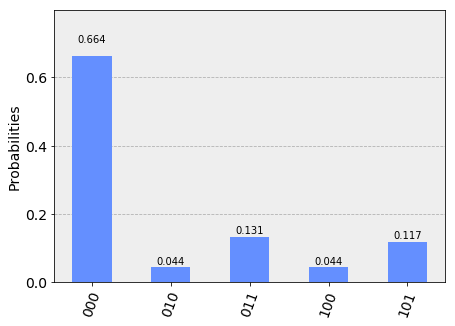

In [8]:
# Run  on the quantum simulator
backend = Aer.get_backend('qasm_simulator')
shots = 8192
job = execute(qc, backend, shots = shots)

# execute
result_sim = job.result()

# obtain results
counts_sim = result_sim.get_counts(qc)
plot_histogram(counts_sim)

In [ ]:
#Prepare an experiment on a real device

# IBMQ.save_account(token)
IBMQ.load_account()


shots = 8192           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 10       # Maximum number of credits to spend on executions. 
n_qubits = 3

# ibmqx2 was found to produce the best results
backend = IBMQ.backends(name = 'ibmqx2')[0]  

In [17]:
# <<<<<<<<<<< EXECUTE on a real device >>>>>>>>>>>>>>
run = 0  # keep 0 untill you want to run the experiment
if run:
    job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    result = job_exp.result()

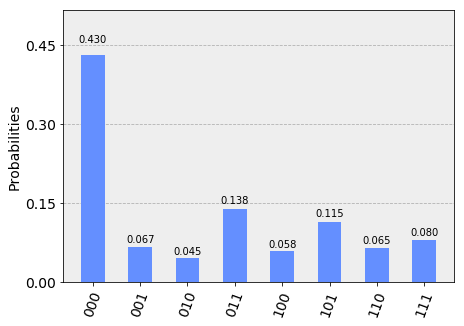

In [18]:
# Uncomment to plot the new results

#counts = result.get_counts(qc)
#plot_histogram(counts)

We include the the best results we obtained, which were from IBMQX2. The measured output state has reasonably high fidelity of ~$80\%$ compared to the expected state. It produces close to the expected values for the measurement probabilities of the $|010\rangle$, $|110\rangle$, $|001\rangle$ and $|101\rangle$ states. However the state $|000\rangle$ seems to have decayed to the states with zero-expected probability, $\left| 100 \right\rangle$, $\left| 011 \right\rangle$, and $\left| 111 \right\rangle$. 

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright